<a href="https://colab.research.google.com/github/wu-warren/Feedforward-Neural-Network-for-Nonlinear-Classification/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm, trange

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
a = torch.randn(1000,1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a_cuda = a.to(device) # copying the matrix from cpu to gpu

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='.', train=False, transform=transform, download=True)


train_size = int(0.2 * len(train_dataset))
remaining_size = len(train_dataset) - train_size
train_dataset_split, _ = random_split(train_dataset, [train_size, remaining_size])

train_loader = DataLoader(train_dataset_split, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

In [ ]:
def add_label_noise(dataset, noise_percent):

  noisy_dataset = list(dataset)
  num_noisy_samples = int(len(noisy_dataset) * noise_percent / 100)
  noisy_indices = np.random.choice(len(noisy_dataset), num_noisy_samples, replace=False)

  for i in noisy_indices:
    original_image, original_label = noisy_dataset[i]
    all_labels = list(range(10))
    all_labels.remove(original_label)
    new_label = np.random.choice(all_labels)
    noisy_dataset[i] = (original_image, new_label)

  return noisy_dataset


train_dataset_noisy = add_label_noise(train_dataset, 15)
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=32, shuffle=True)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2000),
            nn.ReLU(),
            nn.Linear(2000, 10)
        )

    def forward(self, x):
        return self.net(x)

model = Net()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # move model to gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
weight_decay_model = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay_model = Net().to(device) # move model to gpu

weight_decay_criterion = nn.CrossEntropyLoss()
weight_decay_optimizer = optim.SGD(weight_decay_model.parameters(), lr=0.001, weight_decay = 0.25)

In [ ]:
def download_params(model, filename):
  torch.save(model.state_dict(), filename)

def upload_params(model, filename):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(filename, map_location=device))
    model.to(device)

In [ ]:
model = Net()
filename = "model_no_lambda.pt"
upload_params(model, filename)

FileNotFoundError: [Errno 2] No such file or directory: 'model_no_lambda.pt'

In [ ]:
def train_model(model, device, train_loader, test_loader, criterion, optimizer, epochs, calculate_accuracy=True):
    history_loss = []
    history_accuracy = []

    for epoch in trange(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        history_loss.append(total_loss / len(train_loader))

        if calculate_accuracy:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            history_accuracy.append(accuracy)

    if calculate_accuracy:
        return history_loss, history_accuracy
    else:
        return history_loss, None

In [ ]:
def evaluate_training_accuracy(model, device, train_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return correct / total

In [ ]:
def test_model(model, device, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return correct / total

In [ ]:
history_loss, history_accuracy = train_model(weight_decay_model, device, train_loader_noisy, test_loader, weight_decay_criterion, weight_decay_optimizer, 1000, calculate_accuracy=False)
download_params(weight_decay_model, "model_lambda_0_25.pt")

  6%|▌         | 59/1000 [02:40<43:46,  2.79s/it]

In [ ]:
!nvidia-smi


Wed Jun  4 05:44:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             31W /   70W |     200MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print(evaluate_training_accuracy(weight_decay_model, device, train_loader))
print(test_model(weight_decay_model, device, test_loader))

0.8304166666666667
0.8411


Introducing Adversarial Attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        data_denorm = denorm(data)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = model(perturbed_data_normalized)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    return final_acc, adv_examples

In [ ]:
# changed this to a function btw, probably should clean up parameters and such
def adversarial_test(model):
  accuracies = []
  examples = []
  epsilons = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

  # Run test for each epsilon
  for eps in epsilons:
      acc, ex = test(model, device, test_loader, eps)
      accuracies.append(acc)
      examples.append(ex)

  return accuracies, examples

#adverse_accuracy, _ = adversarial_test(model)

In [ ]:
model_1 = Net().to(device)
model_2 = Net().to(device)
model_3 = Net().to(device)
model_4 = Net().to(device)
model_5 = Net().to(device)

filenames = [
    "model_no_lambda (1).pt",
    "model_lambda_e-1.pt",
    "model_lambda_1e-2.pt",
    "model_lambda_e-3.pt",
    "model_lambda_1 (1).pt"
]

upload_params(model_1, filenames[0])
upload_params(model_2, filenames[1])
upload_params(model_3, filenames[2])
upload_params(model_4, filenames[3])
upload_params(model_5, filenames[4])



Epsilon: 0	Test Accuracy = 9762 / 10000 = 0.9762
Epsilon: 0.005	Test Accuracy = 9114 / 10000 = 0.9114
Epsilon: 0.01	Test Accuracy = 6909 / 10000 = 0.6909
Epsilon: 0.015	Test Accuracy = 2203 / 10000 = 0.2203
Epsilon: 0.02	Test Accuracy = 158 / 10000 = 0.0158
Epsilon: 0.025	Test Accuracy = 9 / 10000 = 0.0009
Epsilon: 0.03	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0	Test Accuracy = 8411 / 10000 = 0.8411
Epsilon: 0.005	Test Accuracy = 7993 / 10000 = 0.7993
Epsilon: 0.01	Test Accuracy = 7599 / 10000 = 0.7599
Epsilon: 0.015	Test Accuracy = 7141 / 10000 = 0.7141
Epsilon: 0.02	Test Accuracy = 6615 / 10000 = 0.6615
Epsilon: 0.025	Test Accuracy = 6005 / 10000 = 0.6005
Epsilon: 0.03	Test Accuracy = 5396 / 10000 = 0.5396
Epsilon: 0	Test Accuracy = 9779 / 10000 = 0.9779
Epsilon: 0.005	Test Accuracy = 9351 / 10000 = 0.9351
Epsilon: 0.01	Test Accuracy = 8223 / 10000 = 0.8223
Epsilon: 0.015	Test Accuracy = 5548 / 10000 = 0.5548
Epsilon: 0.02	Test Accuracy = 1811 / 10000 = 0.1811
Epsilon: 0.025	Test Acc

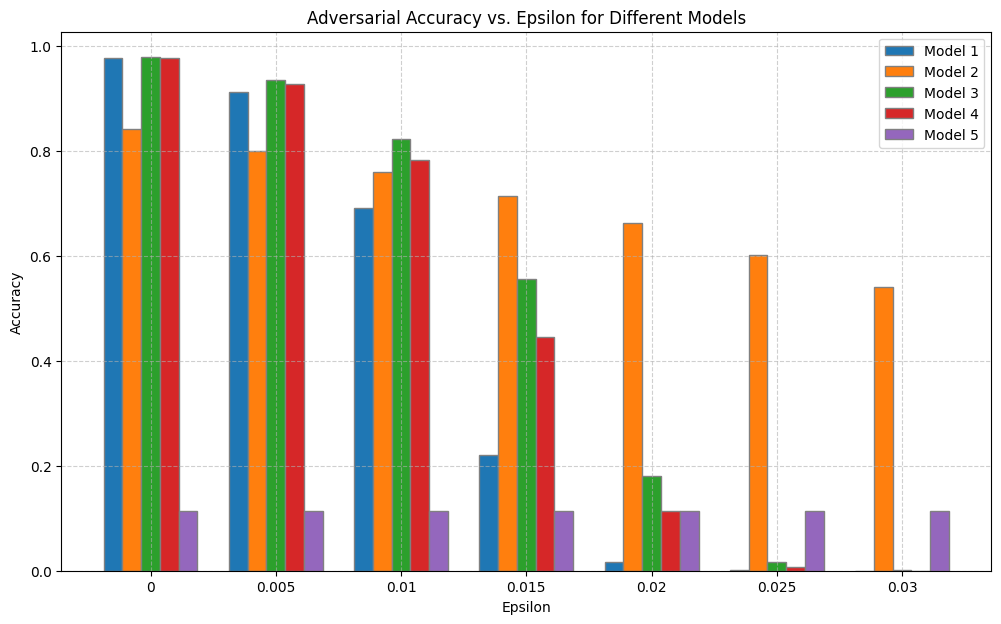

In [ ]:
def plot_adversarial_accuracy(models):
  epsilons = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
  all_accuracies = []
  model_names = [f"Model {i+1}" for i in range(len(models))]

  for model in models:
    accuracies, _ = adversarial_test(model)
    all_accuracies.append(accuracies)

  bar_width = 0.15
  r = np.arange(len(epsilons))

  plt.figure(figsize=(12, 7))

  for i, accuracies in enumerate(all_accuracies):
    plt.bar(r + i * bar_width, accuracies, color=f'C{i}', width=bar_width, edgecolor='grey', label=model_names[i])

  plt.xlabel('Epsilon')
  plt.ylabel('Accuracy')
  plt.title('Adversarial Accuracy vs. Epsilon for Different Models')
  plt.xticks([j + bar_width * (len(models) - 1) / 2 for j in r], epsilons)
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.show()

models_to_compare = [model_1, model_2, model_3, model_4, model_5]
plot_adversarial_accuracy(models_to_compare)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_84/2739717477.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Adverse Accuracy for Different Epsilon Values with no $\lambda$ ')


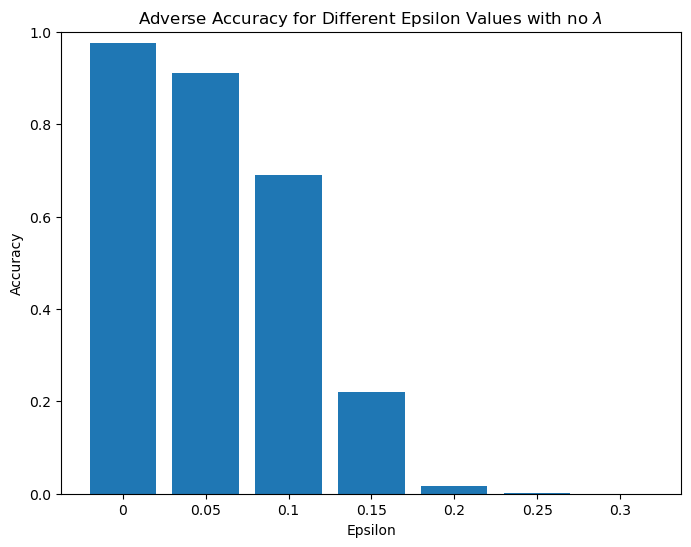

In [ ]:
labels = [f'{e}' for e in [0, .05, .1, .15, .2, .25, .3]]
plt.figure(figsize=(8, 6))
plt.bar(labels, adverse_accuracy)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Adverse Accuracy for Different Epsilon Values with no $\lambda$ ')
plt.ylim(0, 1)
plt.show()


In [ ]:
adversarial_test(weight_decay_model) # looks like higher regularization parameter makes the model better against adversarial data--not good, but better

Epsilon: 0	Test Accuracy = 8456 / 10000 = 0.8456
Epsilon: 0.05	Test Accuracy = 2124 / 10000 = 0.2124
Epsilon: 0.1	Test Accuracy = 15 / 10000 = 0.0015
Epsilon: 0.15	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


In [ ]:
def adversarial_train(model, device, train_loader, optimizer, criterion,
                      epsilon, epochs):
    history_loss = []
    model.train()

    for epoch in trange(epochs, desc="FGSM Adversarial Training Epoch"):
        total_loss = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True

            output = model(images)
            loss_for_grad = criterion(output, labels)

            model.zero_grad()
            loss_for_grad.backward()
            data_grad = images.grad.data

            # The magic numbers are mean and std of the MNSIT data set
            perturbed_images = transforms.Normalize((0.1307,), (0.3081,))(
                fgsm_attack(denorm(images), epsilon, data_grad)
            )

            preds = model(perturbed_images)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        history_loss.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - FGSM Adversarial Loss: {avg_loss}")

    return history_loss


In [ ]:
adverse_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adverse_model.parameters(), lr=0.001)

ADV_EPSILON = 0.1         # Can play around with this number
TRAIN_EPOCHS = 5

adversarial_history_loss = adversarial_train(
    model=adverse_model,
    device=device,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epsilon=ADV_EPSILON,
    epochs=TRAIN_EPOCHS
)

FGSM Adversarial Training Epoch:  20%|██        | 1/5 [00:10<00:42, 10.56s/it]

Epoch 1/5 - FGSM Adversarial Loss: 2.7098217487335203


FGSM Adversarial Training Epoch:  40%|████      | 2/5 [00:20<00:30, 10.29s/it]

Epoch 2/5 - FGSM Adversarial Loss: 2.384699422073364


FGSM Adversarial Training Epoch:  40%|████      | 2/5 [00:24<00:37, 12.44s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(adversarial_history_loss)
plt.xlabel('Epochs')
plt.ylabel('Adversarial Loss')
plt.yscale('log')
plt.title('Adversarial Training Loss over Epochs')
plt.show()

In [ ]:
adversarial_test(adverse_model)

In [ ]:


adverse_weight_decay_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adverse_model.parameters(), lr=0.001)

ADV_EPSILON = 0.1         # Can play around with this number
TRAIN_EPOCHS = 5

adversarial_history_loss = adversarial_train(
    model=adverse_weight_decay_model,
    device=device,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epsilon=ADV_EPSILON,
    epochs=TRAIN_EPOCHS
)